In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.decomposition import PCA

from scipy.stats import dirichlet, multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

from inputs.em_clustering import em_algorithm

from inputs.em_clustering import em_algorithm_with_best_init
from inputs.em_clustering import em_algorithm_criterion




## Data simulation

Data shape: (39963, 100)
Labels shape: (39963,)
Well labels shape: (39963,)
Proportions by well shape: (20, 4)
Proportions des clusters par puits :
Puits 1: [0.26328734 0.24715559 0.24477833 0.24477874]
Puits 2: [0.27027962 0.21759004 0.24048986 0.27164048]
Puits 3: [0.2637446  0.26921247 0.24506016 0.22198277]
Puits 4: [0.23402107 0.23771967 0.24642075 0.2818385 ]
Puits 5: [0.24497528 0.26791779 0.23542265 0.25168428]
Puits 6: [0.22610321 0.25749561 0.25999157 0.25640962]
Puits 7: [0.25706802 0.23754312 0.25284997 0.25253889]
Puits 8: [0.26008812 0.20964487 0.25922379 0.27104322]
Puits 9: [0.22052662 0.22718882 0.29733964 0.25494492]
Puits 10: [0.23767269 0.22902395 0.2478474  0.28545596]
Puits 11: [0.25506035 0.25419059 0.24434211 0.24640695]
Puits 12: [0.22637972 0.27413468 0.28272994 0.21675566]
Puits 13: [0.2585597  0.25984298 0.22474342 0.2568539 ]
Puits 14: [0.29442428 0.23679024 0.21103822 0.25774726]
Puits 15: [0.26104609 0.24373433 0.26160793 0.23361164]
Puits 16: [0.27816272

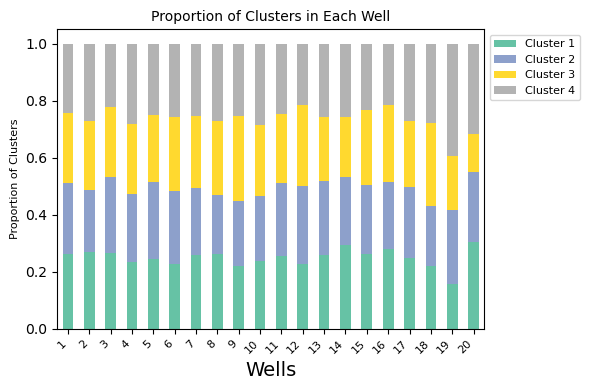

In [2]:
np.random.seed(42)

n_clusters = 4
n_features = 100
n_wells = 20
n_cells_per_well = 2000
t = 4
alpha = 100
beta = 1


mu = np.array([t * (k - 1) * np.ones(n_features) for k in range(1, n_clusters + 1)])
sigma = [np.eye(n_features) for _ in range(n_clusters)]
eta_values = np.concatenate([
    np.ones(int(n_wells / 2) - 1), 
    np.linspace(1, 0, n_wells + 1 - int(n_wells / 2))
])


def simulate_data(alpha, beta, n_wells, mu, sigma, eta_values, n_clusters, n_features, n_cells_per_well):
    data = []
    labels = []
    well_labels = []
    proportions_by_well = []
    
    for well in range(n_wells):
        eta = eta_values[well]
        #print(eta)
        gamma = eta * alpha + (1 - eta) * beta
        proportions = np.random.dirichlet([gamma] * n_clusters)
        proportions_by_well.append(proportions)
        
        for cluster, (mean, cov) in enumerate(zip(mu, sigma)):
            n_points = int(proportions[cluster] * n_cells_per_well)
            cluster_data = multivariate_normal.rvs(mean, cov, size=n_points)
            
            data.append(cluster_data)
            labels.extend([cluster] * n_points)
            well_labels.extend([well] * n_points)
    
    data = np.vstack(data)
    labels = np.array(labels)
    well_labels = np.array(well_labels)
    proportions_by_well = np.array(proportions_by_well)
    
    return data, labels, well_labels, proportions_by_well

data, labels, well_labels, proportions_by_well = simulate_data(alpha, beta, n_wells, mu, sigma, eta_values, n_clusters, n_features, n_cells_per_well)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Well labels shape:", well_labels.shape)
print("Proportions by well shape:", proportions_by_well.shape)




print("Proportions des clusters par puits :")
for i, proportions in enumerate(proportions_by_well):
    print(f"Puits {i+1}: {proportions}")





# plot data simulated 


prop_wells = np.array(proportions_by_well)       


well_labels = [f'{i + 1}' for i in range(n_wells)]
clusters = [f'Cluster {i + 1}' for i in range(n_clusters)]


df = pd.DataFrame(prop_wells, columns=clusters)
df['Well'] = well_labels


df.set_index('Well').plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set2')

plt.title('Proportion of Clusters in Each Well', fontsize=10)
plt.xlabel('Wells', fontsize=14)
plt.ylabel('Proportion of Clusters', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(fontsize=8, bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()



### Trying the inter-classe distance influence 

In [29]:
n_clusters = 4
n_features = 10
n_wells = 20
n_cells_per_well = 2000
alpha = 100
beta = 1

t_values = [0.5,1, 2, 3, 4, 5]
results = []

for t in t_values:
    print(f"\n===== t = {t} =====")

    mu = np.array([t*(k - 1) * np.ones(n_features) + np.random.normal(0, 0.5, n_features) 
               for k in range(1, n_clusters + 1)])
    sigma = [np.eye(n_features) * 2 for _ in range(n_clusters)]  # plus de variance
    eta_values = np.concatenate([
        np.ones(int(n_wells / 2) - 1), 
        np.linspace(1, 0, n_wells + 1 - int(n_wells / 2))
    ])
    
    data, true_labels, well_labels, _ = simulate_data(
        alpha, beta, n_wells, mu, sigma,
        eta_values, n_clusters, n_features, n_cells_per_well
    )

    # EM
    mu_hat, Sigma_hat, pi_hat, alpha_hat = em_algorithm_with_best_init(data, K=n_clusters)
    predicted_clusters = np.argmax(alpha_hat, axis=1)

    # Scores
    ari = adjusted_rand_score(true_labels, predicted_clusters)
    nmi = normalized_mutual_info_score(true_labels, predicted_clusters)
    
    print(f"ARI: {ari:.4f} | NMI: {nmi:.4f}")
    
    results.append({
        't': t,
        'ARI': ari,
        'NMI': nmi
    })

df_results = pd.DataFrame(results)
print("\nSummary of performances:")
print(df_results)


===== t = 0.5 =====
ARI: 0.2804 | NMI: 0.3315

===== t = 1 =====
ARI: 0.6079 | NMI: 0.6245

===== t = 2 =====
ARI: 0.9272 | NMI: 0.9119

===== t = 3 =====
ARI: 0.9995 | NMI: 0.9986

===== t = 4 =====
ARI: 1.0000 | NMI: 1.0000

===== t = 5 =====
ARI: 1.0000 | NMI: 1.0000

Summary of performances:
     t       ARI       NMI
0  0.5  0.280383  0.331548
1  1.0  0.607871  0.624491
2  2.0  0.927242  0.911896
3  3.0  0.999460  0.998647
4  4.0  1.000000  1.000000
5  5.0  1.000000  1.000000


### Proportion of Errors

In [ ]:
n_clusters = 4
n_features = 10
n_wells = 20
n_cells_per_well = 200
alpha = 100
beta = 1

def calculate_proportion_errors(true_proportions, estimated_pi, n_clusters):
    prop_errors = []
    for perm in itertools.permutations(range(n_clusters)):  
        permuted_proportions = estimated_pi[list(perm)]
        prop_error = np.abs(true_proportions - permuted_proportions).mean()
        prop_errors.append(prop_error)
    return min(prop_errors)


t_values = [0.5, 1, 2, 3,4, 5]
n_simulations = 100

results = []

for t in t_values:
    mu = np.array([t * (k - 1) * np.ones(n_features) for k in range(1, n_clusters + 1)])
    sigma = [np.eye(n_features) for _ in range(n_clusters)]
    eta_values = np.concatenate([
        np.ones(int(n_wells / 2) - 1), 
        np.linspace(1, 0, n_wells + 1 - int(n_wells / 2))
    ])

    prop_errors = []  

    for _ in range(n_simulations):
        data, labels, well_labels, proportions_by_well = simulate_data(
            alpha, beta, n_wells, mu, sigma, eta_values, n_clusters, n_features, n_cells_per_well
        )

        estimated_mu, estimated_Sigma, estimated_pi, alpha = em_algorithm(data, n_clusters)

        true_proportions = proportions_by_well.mean(axis=0)

        prop_error = calculate_proportion_errors(true_proportions, estimated_pi, n_clusters)
        prop_errors.append(prop_error)

    results.append({
        "t": t,
        "prop_error": np.mean(prop_errors)
    })


for result in results:
    print(f"t = {result['t']}:")
    print(f"  Proportion Error: {result['prop_error']}")




t = 0.5:
  Proportion Error: 0.04650537272393706
t = 1:
  Proportion Error: 0.0045295196776918125
t = 2:
  Proportion Error: 0.03574479971832202
t = 3:
  Proportion Error: 0.06098485537827318
t = 4:
  Proportion Error: 0.04754930078252385
t = 5:
  Proportion Error: 0.039131852510237104


### Criteria Selection

In [ ]:
n_simulations = 100
n_clusters = 4
n_samples = 200
n_features = 50
n_wells = 10
t = 3  
alpha = 10
beta = 1

K_values = range(2, 7)  

mu = np.array([t * (k - 1) * np.ones(n_features) for k in range(1, n_clusters + 1)])
sigma = [np.eye(n_features) for _ in range(n_clusters)]
eta_values = np.concatenate([
    np.ones(int(n_wells / 2) - 1), 
    np.linspace(1, 0, n_wells + 1 - int(n_wells / 2))
])

bic_all = np.zeros((n_simulations, len(K_values)))
aic_all = np.zeros((n_simulations, len(K_values)))
icl_all = np.zeros((n_simulations, len(K_values)))

for sim in range(n_simulations):
    data, labels, well_labels, proportions = simulate_data(
        alpha=alpha,
        beta=beta,
        n_wells=n_wells,
        mu=mu,
        sigma=sigma,
        eta_values=eta_values,
        n_clusters=n_clusters,
        n_features=n_features,
        n_cells_per_well=n_cells_per_well
    )


    for idx, K in enumerate(K_values):
        _, _, _, _, bic, aic, icl = em_algorithm_criterion(data, K, n_wells)
        bic_all[sim, idx] = bic
        aic_all[sim, idx] = aic
        icl_all[sim, idx] = icl


bic_mean = bic_all.mean(axis=0)
aic_mean = aic_all.mean(axis=0)
icl_mean = icl_all.mean(axis=0)

optimal_K_bic = K_values[np.argmin(bic_mean)]
optimal_K_aic = K_values[np.argmin(aic_mean)]
optimal_K_icl = K_values[np.argmin(icl_mean)]

print(f"Optimal K based on mean BIC over simulations: {optimal_K_bic}")
print(f"Optimal K based on mean AIC over simulations: {optimal_K_aic}")
print(f"Optimal K based on mean ICL over simulations: {optimal_K_icl}")

K=2, Log-likelihood=-2017289.71, Log-likelihood Complete=-2017289.71, Num Params=210, BIC=4036658.93, AIC=4034999.42, ICL=4036658.93
K=3, Log-likelihood=-1710835.74, Log-likelihood Complete=-1710835.74, Num Params=320, BIC=3424840.25, AIC=3422311.49, ICL=3424840.25
K=4, Log-likelihood=-1444909.21, Log-likelihood Complete=-1444909.21, Num Params=430, BIC=2894076.44, AIC=2890678.41, ICL=2894076.44
K=5, Log-likelihood=-1444795.35, Log-likelihood Complete=-1444852.26, Num Params=540, BIC=2894937.99, AIC=2890670.70, ICL=2895051.81
Initialization 8/10 failed: When `allow_singular is False`, the input matrix must be symmetric positive definite.
K=6, Log-likelihood=-1444719.15, Log-likelihood Complete=-1447547.57, Num Params=650, BIC=2895874.84, AIC=2890738.29, ICL=2901531.68
K=2, Log-likelihood=-2018286.92, Log-likelihood Complete=-2018286.92, Num Params=210, BIC=4038653.36, AIC=4036993.85, ICL=4038653.36
K=3, Log-likelihood=-1730266.32, Log-likelihood Complete=-1730266.32, Num Params=320, BI

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_multivariate.py:114: RuntimeWarning: overflow encountered in scalar divide
  return np.array([0 if abs(x) <= eps else 1/x for x in v], dtype=float)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_multivariate.py:176: RuntimeWarning: invalid value encountered in multiply
  U = np.multiply(u, np.sqrt(s_pinv))
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP


Initialization 10/10 failed: When `allow_singular is False`, the input matrix must be symmetric positive definite.
K=6, Log-likelihood=-1445904.00, Log-likelihood Complete=-1446696.67, Num Params=650, BIC=2898244.75, AIC=2893108.00, ICL=2899830.08
K=2, Log-likelihood=-2018985.56, Log-likelihood Complete=-2018985.56, Num Params=210, BIC=4040050.64, AIC=4038391.12, ICL=4040050.64
K=3, Log-likelihood=-1724136.89, Log-likelihood Complete=-1724136.89, Num Params=320, BIC=3451442.58, AIC=3448913.78, ICL=3451442.58
K=4, Log-likelihood=-1444642.17, Log-likelihood Complete=-1444642.17, Num Params=430, BIC=2893542.41, AIC=2890144.34, ICL=2893542.41
K=5, Log-likelihood=-1444536.78, Log-likelihood Complete=-1444578.32, Num Params=540, BIC=2894420.89, AIC=2890153.55, ICL=2894503.99


In [41]:
bic_mean = bic_all.mean(axis=0)
aic_mean = aic_all.mean(axis=0)
icl_mean = icl_all.mean(axis=0)

optimal_K_bic = K_values[np.argmin(bic_mean)]
optimal_K_aic = K_values[np.argmin(aic_mean)]
optimal_K_icl = K_values[np.argmin(icl_mean)]

print(f"Optimal K based on mean BIC over simulations: {optimal_K_bic}")
print(f"Optimal K based on mean AIC over simulations: {optimal_K_aic}")
print(f"Optimal K based on mean ICL over simulations: {optimal_K_icl}")

Optimal K based on mean BIC over simulations: 5
Optimal K based on mean AIC over simulations: 5
Optimal K based on mean ICL over simulations: 4


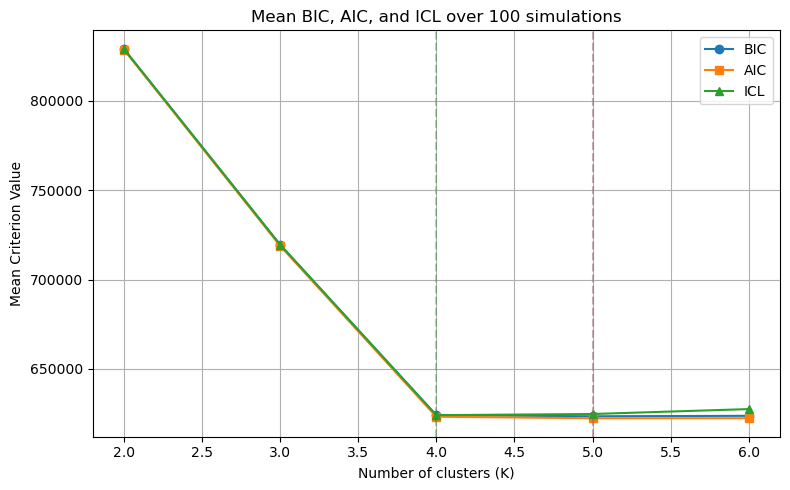

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(K_values, bic_mean, marker='o', label='BIC')
plt.plot(K_values, aic_mean, marker='s', label='AIC')
plt.plot(K_values, icl_mean, marker='^', label='ICL')

plt.axvline(optimal_K_bic, color='blue', linestyle='--', alpha=0.3)
plt.axvline(optimal_K_aic, color='orange', linestyle='--', alpha=0.3)
plt.axvline(optimal_K_icl, color='green', linestyle='--', alpha=0.3)

plt.xlabel("Number of clusters (K)")
plt.ylabel("Mean Criterion Value")
plt.title("Mean BIC, AIC, and ICL over 100 simulations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


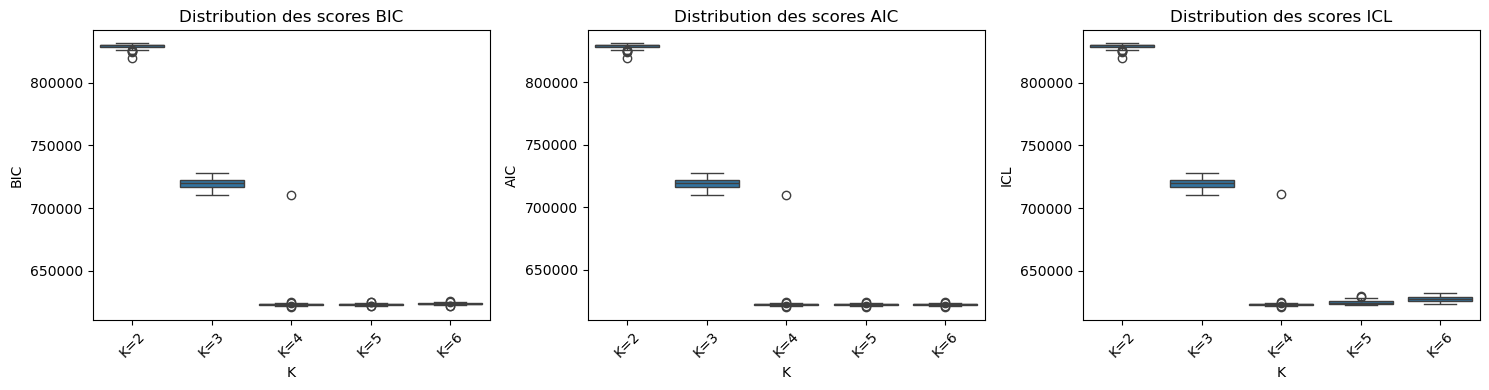

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose bic_all, aic_all, icl_all sont de taille (100, len(K_values))
columns = [f"K={k}" for k in K_values]

bic_df = pd.DataFrame(bic_all, columns=columns)
aic_df = pd.DataFrame(aic_all, columns=columns)
icl_df = pd.DataFrame(icl_all, columns=columns)

# Transformation en format long pour seaborn
bic_long = bic_df.melt(var_name="K", value_name="BIC")
aic_long = aic_df.melt(var_name="K", value_name="AIC")
icl_long = icl_df.melt(var_name="K", value_name="ICL")

# Affichage
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=bic_long, x="K", y="BIC")
plt.title("Distribution des scores BIC")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=aic_long, x="K", y="AIC")
plt.title("Distribution des scores AIC")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=icl_long, x="K", y="ICL")
plt.title("Distribution des scores ICL")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
